# Data prepare 

This segment prepares dataset containig normalized sound recordings extended with temperature and humidity values. For now we support only one hive for data preparation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# 1300001 - hive
# 1300002 - not hive?
# 1400001 - hive szymanski
# 1400002 - hive szymanski
#hives_ids = [1300001, 1300002, 1400001, 1400002]

hives_ids = [1300001, 1300002]
DATA_INIT = True

night_start_hour = 19
night_end_hour = 7

In [3]:
if DATA_INIT:
    hives_temperature = [pd.read_csv(f"measurements/{hive_id}/temperature.csv") for hive_id in hives_ids]
    hives_humidity = [pd.read_csv(f"measurements/{hive_id}/humidity.csv") for hive_id in hives_ids]
    hives_humidity = [hive_hum.drop_duplicates(subset=['timestamp'], keep = False) for hive_hum in hives_humidity]
    hives_temperature = [hive_tem.drop_duplicates(subset=['timestamp'], keep = False) for hive_tem in hives_temperature]
    
    hives_atmosphere = [pd.merge(
        hives_humidity[idx], hives_temperature[idx], on='timestamp',
        suffixes=(f"_humidity_{hive_id}",f"_temperature_{hive_id}"))
               for idx, hive_id in enumerate(hives_ids)]

    total = 0
    for idx, hive_atmosphere in enumerate(hives_atmosphere):
        hive_atmosphere['timestamp'] = pd.to_datetime(
            hive_atmosphere['timestamp'], format = '%Y-%m-%dT%H-%M-%S').sort_values()
        hive_atmosphere.set_index('timestamp', inplace = True)
        print(f"Hive with id: {hives_ids[idx]} has atmospheric data with size: {hive_atmosphere.shape}")
        total += hive_atmosphere.shape[0]
    
    print(f"Total atmoshpere dataset size: {total}")

Hive with id: 1300001 has atmospheric data with size: (6696, 2)
Hive with id: 1300002 has atmospheric data with size: (6778, 2)
Total atmoshpere dataset size: 13474


In [4]:
import glob
from scipy.fftpack import rfft
from scipy.signal import blackman
import librosa

if DATA_INIT:
    total_night_samples = 0
    hives_data = []
    for idx, hive_id in enumerate(hives_ids):
        sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        print(f"Sound data preparation for hive: {hive_id} which has {len(sound_files)} recordings")
        for file in tqdm(sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            np_samples = np.array(df_samples['samples'].values, dtype="float32") # sound samples
            rms = np.sqrt(np_samples.dot(np_samples)/np_samples.size)            # root mean square power
            rms = (3.3*rms)/4096
            if(len(df_samples.index) == 3000 and np_samples.max() < 4500):
                np_samples = np_samples / 4080
                            
                # FFT, get rid of DC compoment by subtracting average
                np_spectogram = 20*np.log10(np.abs(np.fft.rfft(
                    (np_samples - np.mean(np_samples)) * np.hamming(3000))) / 4080)
                
                # MFCC
                # mfccs = librosa.feature.mfcc(y=np_samples, sr=3000, n_fft=512, hop_length=256, n_mfcc=14)
                mfccs = librosa.feature.mfcc(y=np_samples, sr=3000, n_fft=150, hop_length=75, n_mfcc=13)
                np_mfcc_avg = np.mean(mfccs, axis=1)
                np_mfcc_var = np.var(mfccs, axis=1)

                # Night label
                is_night = (pd_timestamp.hour > night_start_hour or pd_timestamp.hour < night_end_hour)
                if is_night: 
                    total_night_samples = total_night_samples + 1
                
                # Atmosphere
                df_nerest = hives_atmosphere[idx].iloc[
                    hives_atmosphere[idx].index.get_loc(pd_timestamp, method='nearest')]
                
                hives_data.append([pd_timestamp, hive_id, is_night,
                                    df_nerest[f"value_temperature_{hive_id}"],
                                    df_nerest[f"value_humidity_{hive_id}"],
                                    np_samples, np_spectogram, np_mfcc_avg, np_mfcc_var, rms])
    
    print(f'Creating dataset with {total_night_samples} night samples for data size: {len(hives_data)}')
    print(f'Night percentage: {round(100*total_night_samples/len(hives_data), 2)}')
    np.save('hives-data.npy', hives_data)
else:
    hives_data = np.load('hives-data.npy', allow_pickle = True)
    print(f"Loaded dataset with size {len(hives_data)}.")
    
df_hives_data = pd.DataFrame(hives_data,
                           columns=['timestamp', 'hive_id', 'is_night',
                                    'temperature', 'humidity',
                                    'samples', 'fft', 'mfcc_avg', 'mfcc_var', 'rms'])
df_hives_data = df_hives_data.set_index('timestamp')

Sound data preparation for hive: 1300001 which has 1664 recordings


100%|██████████| 1664/1664 [00:15<00:00, 105.53it/s]


Sound data preparation for hive: 1300002 which has 1637 recordings


100%|██████████| 1637/1637 [00:17<00:00, 92.28it/s] 


Creating dataset with 1530 night samples for data size: 3245
Night percentage: 47.15


In [5]:
outdoor = df_hives_data[df_hives_data.hive_id == 1300002]
df_hive_1300001 = df_hives_data[df_hives_data.hive_id == 1300001]
df_hive_1400001 = df_hives_data[df_hives_data.hive_id == 1400001]
df_hive_1400002 = df_hives_data[df_hives_data.hive_id == 1400002]

# Temperaturowe ekstrema

In [ ]:
nearest_outdoor_idx = [outdoor.index.get_loc(df_hive_1300001.index[i], method='nearest')
                       for i in range(df_hive_1300001.shape[0])]
temperature_diffs = [abs(df_hive_1300001.iloc[i]['temperature'] - outdoor.iloc[nearest_outdoor_idx[i]]['temperature']) 
                     for i in range(df_hive_1300001.shape[0])]
humidity_diffs = [abs(df_hive_1300001.iloc[i]['humidity'] - outdoor.iloc[nearest_outdoor_idx[i]]['humidity']) 
                     for i in range(df_hive_1300001.shape[0])]

zipped = list(zip(temperature_diffs, humidity_diffs, ))

df_hive_outdoor_diffs = pd.DataFrame(zipped, index=df_hive_1300001.index, columns=['temperature_diff', 'humidity_diff'])

df_hive_outdoor_diffs['loss'] = np.sqrt(np.power(df_hive_outdoor_diffs['temperature_diff'] - df_hive_outdoor_diffs['temperature_diff'].mean(), 2)
        + np.power(df_hive_outdoor_diffs['humidity_diff'] - df_hive_outdoor_diffs['humidity_diff'].mean(), 2))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

hive_1300001_list = df_hive_1300001['mfcc_avg'].tolist()

hive_1300001_list_standarized = StandardScaler().fit_transform(hive_1300001_list)

hive_1300001_pcareduced = PCA(n_components = 2).fit_transform(hive_1300001_list) 

df_hive_1300001_pcareduced = pd.DataFrame(hive_1300001_pcareduced, index=df_hive_1300001.index, columns=['x', 'y'])

In [ ]:
temperature_extreme = df_hive_outdoor_diffs[df_hive_outdoor_diffs['temperature_diff'] > 18]
temperature_normal = df_hive_outdoor_diffs[df_hive_outdoor_diffs['temperature_diff'] < 5]
humidity_extreme = df_hive_outdoor_diffs[df_hive_outdoor_diffs['humidity_diff'] > 45]
humidity_normal = df_hive_outdoor_diffs[df_hive_outdoor_diffs['humidity_diff'] < 10]
loss_extreme = df_hive_outdoor_diffs[df_hive_outdoor_diffs['loss'] > 20]
loss_normal = df_hive_outdoor_diffs[df_hive_outdoor_diffs['loss'] < 5]

df_hive_1300001_pcareduced_tem_subset = df_hive_1300001_pcareduced[df_hive_1300001_pcareduced.index.isin(temperature_normal.index)
                                              | df_hive_1300001_pcareduced.index.isin(temperature_extreme.index)]
df_hive_1300001_pcareduced_hum_subset = df_hive_1300001_pcareduced[df_hive_1300001_pcareduced.index.isin(humidity_normal.index)
                                              | df_hive_1300001_pcareduced.index.isin(humidity_extreme.index)]
df_hive_1300001_pcareduced_loss_subset = df_hive_1300001_pcareduced[df_hive_1300001_pcareduced.index.isin(loss_normal.index)
                                              | df_hive_1300001_pcareduced.index.isin(loss_extreme.index)]

hive_ex_full_tem_labels = df_hive_1300001_pcareduced_tem_subset.index.isin(temperature_extreme.index)
hive_ex_full_hum_labels = df_hive_1300001_pcareduced_hum_subset.index.isin(humidity_extreme.index)
hive_ex_full_loss_labels = df_hive_1300001_pcareduced_loss_subset.index.isin(loss_extreme.index)

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as pl

pca = PCA().fit(hive_1300001_list)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of compone nts')
plt.ylabel('cumulative explained variance');

print(np.cumsum(pca.explained_variance_ratio_[:3]))

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

df_full_night = df_hive_1300001_pcareduced[df_hive_1300001['is_night']]
df_full_day = df_hive_1300001_pcareduced[df_hive_1300001['is_night'] == False]

fig, axs  = plt.subplots(3, 2, figsize=(10,12), sharex=True, sharey=True)

df_tem_extreme = df_hive_1300001_pcareduced_tem_subset[hive_ex_full_tem_labels]
df_tem_normal = df_hive_1300001_pcareduced_tem_subset[hive_ex_full_tem_labels == False]
df_hum_extreme = df_hive_1300001_pcareduced_hum_subset[hive_ex_full_hum_labels]
df_hum_normal = df_hive_1300001_pcareduced_hum_subset[hive_ex_full_hum_labels == False]
df_loss_extreme = df_hive_1300001_pcareduced_loss_subset[hive_ex_full_loss_labels]
df_loss_normal = df_hive_1300001_pcareduced_loss_subset[hive_ex_full_loss_labels == False]

# Chart 1
l1 = axs[0][0].scatter([data[0] for data in df_tem_extreme.to_numpy()],
                 [data[1] for data in df_tem_extreme.to_numpy()], c='r', alpha = 0.3)
l2 = axs[0][0].scatter([data[0] for data in df_tem_normal.to_numpy()],
                 [data[1] for data in df_tem_normal.to_numpy()], c='g', alpha = 0.3)
axs[0][0].legend((l1, l2), ('T Max', 'T Min'), loc='upper right')
axs[0][0].set_xlabel('PC 1')
axs[0][0].set_ylabel('PC 2')
axs[0][0].set_title('Hive 1300001 - Temperature Extreme')

# Chart 2
l1 = axs[0][1].scatter([data[0] for data in df_full_night.to_numpy()],
                 [data[1] for data in df_full_night.to_numpy()], c='cyan', alpha = 0.3)
l2 = axs[0][1].scatter([data[0] for data in df_full_day.to_numpy()],
                 [data[1] for data in df_full_day.to_numpy()], c='black', alpha = 0.3)
axs[0][1].legend((l1, l2), ('Night', 'Day'), loc='upper right')
axs[0][1].set_xlabel('PC 1')
axs[0][1].set_ylabel('PC 2')
axs[0][1].set_title('Hive 1300001 - Full data')

# Chart 3
l1 = axs[1][0].scatter([data[0] for data in df_hum_extreme.to_numpy()],
                 [data[1] for data in df_hum_extreme.to_numpy()], c='r', alpha = 0.3)
l2 = axs[1][0].scatter([data[0] for data in df_hum_normal.to_numpy()],
                 [data[1] for data in df_hum_normal.to_numpy()], c='g', alpha = 0.3)
axs[1][0].legend((l1, l2), ('H Max', 'H Min'), loc='upper right')
axs[1][0].set_xlabel('PC 1')
axs[1][0].set_ylabel('PC 2')
axs[1][0].set_title('Hive 1300001 - Humidity Extreme')

# Chart 4
l1 = axs[1][1].scatter([data[0] for data in df_full_night.to_numpy()],
                 [data[1] for data in df_full_night.to_numpy()], c='cyan', alpha = 0.3)
l2 = axs[1][1].scatter([data[0] for data in df_full_day.to_numpy()],
                 [data[1] for data in df_full_day.to_numpy()], c='black', alpha = 0.3)
axs[1][1].legend((l1, l2), ('Night', 'Day'), loc='upper right')
axs[1][1].set_xlabel('PC 1')
axs[1][1].set_ylabel('PC 2')
axs[1][1].set_title('Hive 1300001 - Full data')

# Chart 5
l1 = axs[2][0].scatter([data[0] for data in df_loss_extreme.to_numpy()],
                 [data[1] for data in df_loss_extreme.to_numpy()], c='r', alpha = 0.3)
l2 = axs[2][0].scatter([data[0] for data in df_loss_normal.to_numpy()],
                 [data[1] for data in df_loss_normal.to_numpy()], c='g', alpha = 0.3)
axs[2][0].legend((l1, l2), ('Loss Max', 'Loss Min'), loc='upper right')
axs[2][0].set_xlabel('PC 1')
axs[2][0].set_ylabel('PC 2')
axs[2][0].set_title('Hive 1300001 - Humidity Extreme')

# Chart 6
l1 = axs[2][1].scatter([data[0] for data in df_full_night.to_numpy()],
                 [data[1] for data in df_full_night.to_numpy()], c='cyan', alpha = 0.3)
l2 = axs[2][1].scatter([data[0] for data in df_full_day.to_numpy()],
                 [data[1] for data in df_full_day.to_numpy()], c='black', alpha = 0.3)
axs[2][1].legend((l1, l2), ('Night', 'Day'), loc='upper right')
axs[2][1].set_xlabel('PC 1')
axs[2][1].set_ylabel('PC 2')
axs[2][1].set_title('Hive 1300001 - Full data')

plt.show()

In [ ]:
hive_classification_data = df_hive_1300001[df_hive_1300001.index.isin(normal.index) 
                                              | df_hive_1300001.index.isin(extreme.index)]

h131_mfcc_list = hive_classification_data['mfcc_avg'].tolist()
h131_extreme_label = hive_classification_data.index.isin(extreme.index)

### GMM

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2).fit(h131_mfcc_list)
predicted = gmm.predict(h131_mfcc_list)

correct_labels = [int(data) for data in h131_extreme_label]

sum_correct = 0
for idx, label_predicted in enumerate(predicted):
    if(label_predicted == correct_labels[idx]):
        sum_correct += 1
        
print(f'KMeans accuracy: {(sum_correct/len(correct_labels)*100)}')

### SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', class_weight='balanced', gamma='auto')
svc.fit(h131_mfcc_list, [int(data) for data in h131_extreme_label])
predicted = svc.predict(h131_mfcc_list)

sum_correct = 0
for idx, label_predicted in enumerate(predicted):
    if(label_predicted == correct_labels[idx]):
        sum_correct += 1
        
print(f'SVM train accuracy: {(sum_correct/len(correct_labels)*100)}')

### Natezenie dzwieku

<IPython.core.display.Javascript object>


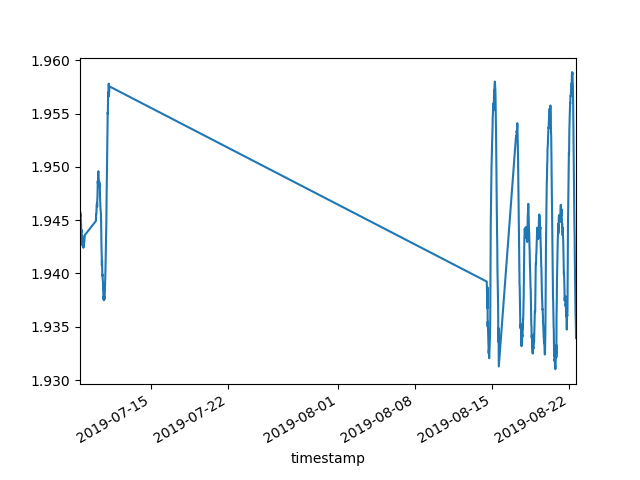

In [34]:
%matplotlib notebook
df_hive_1400002.rms.plot()

In [47]:
interval.tail()

,hive_id,is_night,temperature,humidity,samples,fft,mfcc_avg,mfcc_var,rms
timestamp,,,,,,,,,
2019-08-22 13:32:03,1400002,False,30.21,53.37,"[0.59142154, 0.5870098, 0.5882353, 0.59362745,...","[-86.63751087159703, -82.19342033505967, -102....","[-497.96841915936085, 68.23788618296297, 26.73...","[300.54802066202154, 111.99253693832858, 82.71...",1.936542
2019-08-22 13:50:03,1400002,False,30.75,60.18,"[0.5867647, 0.59166664, 0.5953431, 0.6, 0.5992...","[-88.01100758935165, -82.38627248593286, -90.8...","[-509.5947203620779, 67.30880185987829, 30.693...","[199.38521695073626, 116.57516711071271, 114.6...",1.936002
2019-08-22 14:08:03,1400002,False,30.96,50.12,"[0.57598037, 0.5754902, 0.57990193, 0.5865196,...","[-96.75751126389214, -86.01465246441464, -96.8...","[-523.5631298349582, 68.07889860940892, 35.404...","[168.56401033445678, 107.68901251911338, 100.9...",1.935556
2019-08-22 14:32:03,1400002,False,32.43,69.12,"[0.59068626, 0.5973039, 0.59411764, 0.5852941,...","[-87.94971718844648, -81.45962471300466, -88.0...","[-501.5943120144527, 61.897071632019625, 35.18...","[157.25950936051848, 88.07761002554152, 65.006...",1.934609
2019-08-22 14:38:03,1400002,False,32.53,51.50,"[0.59117645, 0.5865196, 0.5838235, 0.5803922, ...","[-95.4645377233972, -87.42181943334427, -90.74...","[-506.0089342388819, 62.93902058152907, 31.432...","[624.3357488504545, 573.5668514874454, 165.939...",1.933935


In [6]:
#interval = df_hive_1400002
#interval_1 = df_hive_1400002['2019-08-08 02:00:00':]
interval_1 = df_hive_1300001[:'2019-08-09 02:00:00']
interval_2 = df_hive_1300001['2019-08-10 12:30:00':'2019-08-19 14:45:00']
interval_3 = df_hive_1300001['2019-08-23 23:30:00':'2019-08-28 18:30:00']

interval_1 = interval_1[interval_1['rms'] < 1.944]
#interval_2 = interval_1
interval_2 = interval_2[interval_2['rms'] < 1.944]
interval_3 = interval_3[interval_3['rms'] < 1.944]

y_ext_temperatures = []
for idx in range(interval_2.shape[0]):
    hive_timestamp = interval_2.index[idx]
    index_in_outdoor = outdoor.index.get_loc(hive_timestamp, method='nearest')
    sample = outdoor.iloc[index_in_outdoor]
    temperature = sample['temperature']
    outdoor_timestamp = outdoor.index[index_in_outdoor]
    #print(f'For {hive_timestamp} we got sample at {outdoor_timestamp} ({index_in_outdoor}): {temperature}')
    y_ext_temperatures.append(temperature)
    
print(f'Got len for temperature {len(y_ext_temperatures)} and shape for sounds: {interval_2.shape[0]}')

Got len for temperature 806 and shape for sounds: 806


<IPython.core.display.Javascript object>


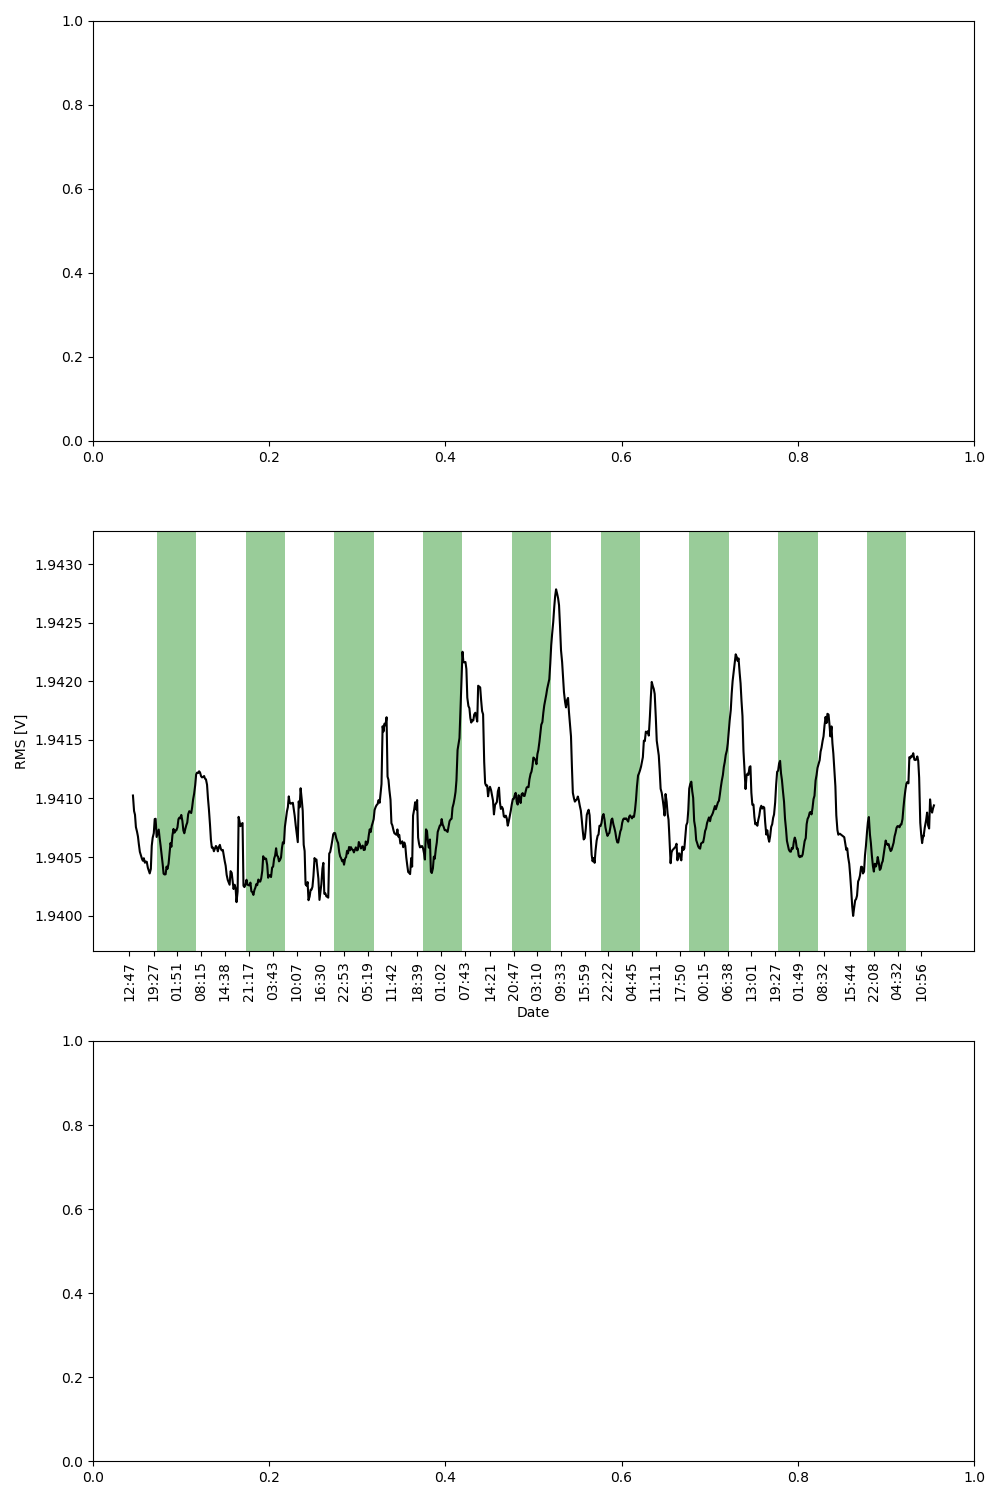

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as dt
import matplotlib.transforms as mtransforms

fig, axs = plt.subplots(3, figsize=(10,15))
fig.subplots_adjust(hspace=0.65)

# First sub interval
# y1 = interval_1['rms'].rolling(window=2).mean().values
# x1 = interval_1.index.values
# xticks = [dt.date2num(x) for x in interval_1.index[::10]]
# xticklabels = [x.strftime('%D %H:%M') for x in interval_1.index[::10]]
# conditions = [x.hour < night_end_hour or x.hour > night_start_hour for x in interval_1.index]
# axs[0].set_title(f'RMS from {interval_1.index[0]} to {interval_1.index[interval_1.shape[0] - 1]}')
# axs[0].plot(x1, y1, color='black')
# axs[0].tick_params(axis='x', rotation=90)
# axs[0].set_xticks(xticks)
# axs[0].set_xticklabels(xticklabels)
# axs[0].set_ylabel('RMS')
# axs[0].set_xlabel('Date')
# axs[0].set_ylim([interval_1['rms'].min(), interval_1['rms'].max()])
# trans = mtransforms.blended_transform_factory(axs[0].transData, axs[0].transAxes)
# axs[0].fill_between(x1, 0, 1, where = conditions, facecolor='green', alpha=0.4, transform=trans)

roll_len = 5
# Second sub interval
y2 = interval_2['rms'].rolling(window=roll_len).mean().values
x2 = interval_2.index.values
# y2_temperature = y_ext_temperatures

# ax2 = axs[1].twinx()
# ax2.set_ylabel('Outdoor temperature [\u00B0C]', color='red')
# ax2.plot(x2, y2_temperature, color='red')
# ax2.tick_params(axis='y', labelcolor='red')
# ax2.set_ylim((5, 100))

xticks = [dt.date2num(x) for x in interval_2.index[::24]]
xticklabels = [x.strftime('%H:%M') for x in interval_2.index[::24]]
conditions = [x.hour < night_end_hour or x.hour > night_start_hour for x in interval_2.index]
#axs[1].set_title(f'RMS and outdoor temperature from {interval_2.index[0]} to {interval_2.index[interval_2.shape[0] - 1]}')
axs[1].plot(x2, y2, color='black')
axs[1].tick_params(axis='x', rotation=90)
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(xticklabels)
axs[1].set_ylabel('RMS [V]', color='black')
axs[1].set_ylim([min(y2[roll_len:])-0.0003, max(y2[roll_len:]) + 0.0005])
axs[1].set_xlabel('Date')
trans = mtransforms.blended_transform_factory(axs[1].transData, axs[1].transAxes)
axs[1].fill_between(x2, 0, 1, where = conditions, facecolor='green', alpha=0.4, transform=trans)

fig.tight_layout()
plt.show()

# Second sub interval
# y1 = interval_3['rms'].rolling(window=3).mean().values
# x1 = interval_3.index.values
# xticks = [dt.date2num(x) for x in interval_3.index[::7]]
# xticklabels = [x.strftime('%D %H:%M') for x in interval_3.index[::7]]
# conditions = [x.hour < night_end_hour or x.hour > night_start_hour for x in interval_3.index]
# axs[2].set_title(f'RMS from {interval_3.index[0]} to {interval_3.index[interval_3.shape[0] - 1]}')
# axs[2].plot(x1, y1, color='black')
# axs[2].tick_params(axis='x', rotation=90)
# axs[2].set_xticks(xticks)
# axs[2].set_xticklabels(xticklabels)
# axs[2].set_ylabel('RMS')
# axs[2].set_xlabel('Date')
# axs[2].set_ylim([interval_3['rms'].min(), interval_3['rms'].max()])
# trans = mtransforms.blended_transform_factory(axs[2].transData, axs[2].transAxes)
# axs[2].fill_between(x1, 0, 1, where = conditions, facecolor='green', alpha=0.4, transform=trans)

In [18]:
x_corelation = np.arange(start=0, step=2, stop=150)

<IPython.core.display.Javascript object>


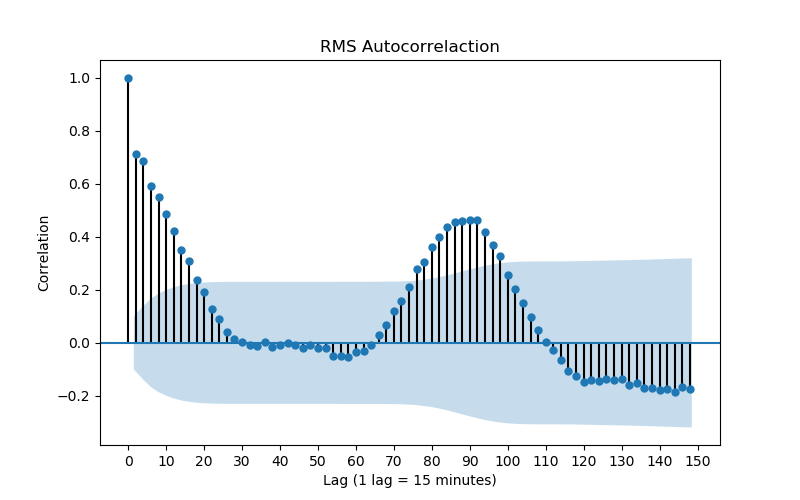

In [19]:
%matplotlib notebook

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, figsize=(8,5))

y_corr = y2[roll_len:]
#y_corr = interval_2['rms'].values.tolist()

x = plot_acf(y_corr, lags=x_corelation, zero=False, ax=axes)
axes.set_title(f'RMS Autocorrelaction')
axes.set_xlabel('Lag (1 lag = 15 minutes)') 
axes.set_ylabel('Correlation')
axes.set_xticks(np.arange(0, 151, step=10))

fig.savefig('autocorrelation.png')
# plot_acf(interval_2['rms'].values.tolist(), lags=100, ax=axes[1])
# plot_acf(interval_3['rms'].values.tolist(), lags=100, ax=axes[2])
# plot_pacf(interval_2['rms'].values.tolist(), lags=100)
# print(f'{interval_2.index[0]} vs {interval_2.index[90]}')

Ponieżej użycie SVM w kontekscie detekcji dnia i nocy na podstawie MFCC i jego rozszerzeń

In [41]:
interval.shape

(585, 9)

In [42]:
# Train data
#hive_train_data = pd.concat([interval_2])
hive_train_data = interval[:450]
# Test data
#hive_test_data = pd.concat([interval_1, interval_3])
hive_test_data = interval[450:]

### Rozszerzenie opcjonalne o temperature i wilgotnosc

In [ ]:
mfccs_train_list = hive_train_data['mfcc_avg'].tolist()
temperature_train_list = hive_train_data['temperature'].tolist()
humidity_train_list = hive_train_data['humidity'].tolist()

final_train_feature_vector = []
for idx, mfccs in enumerate(mfccs_train_list):
    temp = np.concatenate((mfccs, [temperature_train_list[idx]]))
    final_train_feature_vector.append(np.concatenate((temp, [humidity_train_list[idx]])))
    
mfccs_test_list = hive_test_data['mfcc_avg'].tolist()
temperature_test_list = hive_test_data['temperature'].tolist()
humidity_test_list = hive_test_data['humidity'].tolist()

final_test_feature_vector = []
for idx, mfccs in enumerate(mfccs_test_list):
    temp = np.concatenate((mfccs, [temperature_test_list[idx]]))
    final_test_feature_vector.append(np.concatenate((temp, [humidity_test_list[idx]])))

In [43]:
from sklearn.preprocessing import StandardScaler

svm_test_data = hive_test_data['mfcc_avg'].tolist()
svm_train_data = hive_train_data['mfcc_avg'].tolist()

#svm_test_data = final_test_feature_vector
#svm_train_data = final_train_feature_vector

svm_train_data = StandardScaler().fit_transform(svm_train_data)
svm_test_data = StandardScaler().fit_transform(svm_test_data)

print(f'Length of feature vector: {len(svm_train_data[0])}')

Length of feature vector: 13


In [1]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC

start_hours = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

max_accuracy = 0
xes = []
yes = []
cols = []

out_xes = []
out_yes = []
out_cols = []

for shift in range(1, 7):
    for start_hour in start_hours:
        end_hour = (start_hour + shift) % 24
        if end_hour > 12 or start_hour < 7:
            hive_night_train = hive_train_data[(hive_train_data.index.hour >= start_hour) 
                                               & (hive_train_data.index.hour <= end_hour)]
            hive_night_test = hive_test_data[(hive_test_data.index.hour >= start_hour) 
                             & (hive_test_data.index.hour <= end_hour)]
        else:
            hive_night_train = hive_train_data[(hive_train_data.index.hour >= start_hour) 
                                               | (hive_train_data.index.hour <= end_hour)]
            hive_night_test = hive_test_data[(hive_test_data.index.hour >= start_hour) 
                             | (hive_test_data.index.hour <= end_hour)]

        hive_train_data_labels = hive_train_data.index.isin(hive_night_train.index)
        hive_test_data_labels = hive_test_data.index.isin(hive_night_test.index)
        
        svc = SVC(kernel='rbf', class_weight='balanced', gamma='auto')
        svc.fit(svm_train_data, [int(bool_label) for bool_label in hive_train_data_labels])

        predicted = svc.predict(svm_test_data)
        sum_correct = 0
        for idx, label_predicted in enumerate(predicted):
            if(label_predicted == int(hive_test_data_labels[idx])):
                sum_correct += 1

        accuracy = (sum_correct/len(hive_test_data_labels)*100)
        if accuracy > max_accuracy:
            print(f'New max acuuracy for {start_hour} to {end_hour}, accuracy: {accuracy}')
            max_accuracy = accuracy
        print(f'For night start at {start_hour} and end at {end_hour}'
               f' got accuracy: {accuracy}')    
        xes.append(start_hour)
        yes.append(end_hour)
        cols.append(accuracy)
    out_xes.append(xes)
    out_yes.append(yes)
    out_cols.append(cols)
    xes = []
    yes = []
    cols = []

NameError: name 'hive_train_data' is not defined

In [45]:
out = []
for xe in out_xes:
    out_temp = []
    for x in xe:
        if x >= 18:
            x = x - 20
        else:
            x = x + 4
        out_temp.append(x)
    out.append(out_temp)

<IPython.core.display.Javascript object>


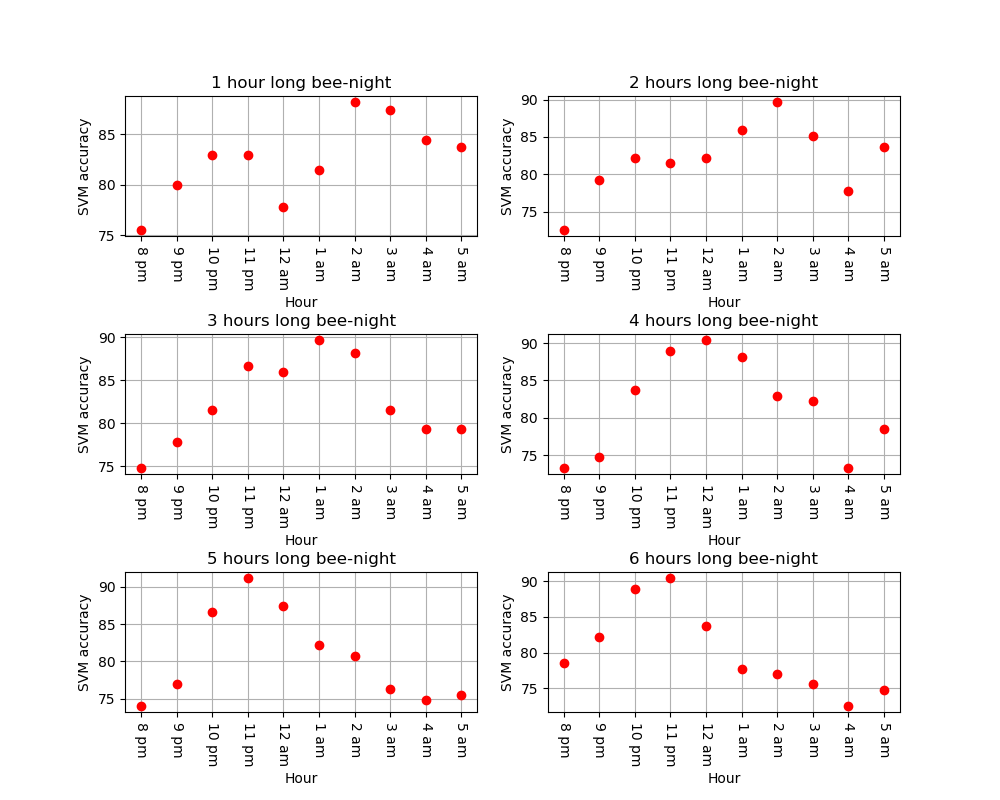

In [46]:
fig, axs  = plt.subplots(3, 2, figsize=(10,8))
fig.subplots_adjust(hspace=0.7)

xticklabels = ['8 pm', '9 pm', '10 pm', '11 pm', '12 am', '1 am', '2 am', '3 am', '4 am', '5 am']

axs[0][0].plot(out[0], out_cols[0], 'ro')
axs[0][0].grid()
axs[0][0].set_xticks(np.arange(0, 10, 1))
axs[0][0].tick_params(axis='x', rotation=270)
axs[0][0].set_xticklabels(xticklabels)
axs[0][0].set_title('1 hour long bee-night')
axs[0][0].set_ylabel('SVM accuracy')
axs[0][0].set_xlabel('Hour')

axs[0][1].plot(out[1], out_cols[1], 'ro')
axs[0][1].grid()
axs[0][1].set_xticks(np.arange(0, 10, 1))
axs[0][1].tick_params(axis='x', rotation=270)
axs[0][1].set_xticklabels(xticklabels)
axs[0][1].set_title('2 hours long bee-night')
axs[0][1].set_ylabel('SVM accuracy')
axs[0][1].set_xlabel('Hour')

axs[1][0].plot(out[2], out_cols[2], 'ro')
axs[1][0].grid()
axs[1][0].set_xticks(np.arange(0, 10, 1))
axs[1][0].tick_params(axis='x', rotation=270)
axs[1][0].set_xticklabels(xticklabels)
axs[1][0].set_title('3 hours long bee-night')
axs[1][0].set_ylabel('SVM accuracy')
axs[1][0].set_xlabel('Hour')

axs[1][1].plot(out[3], out_cols[3], 'ro')
axs[1][1].grid()
axs[1][1].set_xticks(np.arange(0, 10, 1))
axs[1][1].tick_params(axis='x', rotation=270)
axs[1][1].set_xticklabels(xticklabels)
axs[1][1].set_title('4 hours long bee-night')
axs[1][1].set_ylabel('SVM accuracy')
axs[1][1].set_xlabel('Hour')

axs[2][0].plot(out[4], out_cols[4], 'ro')
axs[2][0].grid()
axs[2][0].set_xticks(np.arange(0, 10, 1))
axs[2][0].tick_params(axis='x', rotation=270)
axs[2][0].set_xticklabels(xticklabels)
axs[2][0].set_title('5 hours long bee-night')
axs[2][0].set_ylabel('SVM accuracy')
axs[2][0].set_xlabel('Hour')

axs[2][1].plot(out[5], out_cols[5], 'ro')
axs[2][1].grid()
axs[2][1].set_xticks(np.arange(0, 10, 1))
axs[2][1].tick_params(axis='x', rotation=270)
axs[2][1].set_xticklabels(xticklabels)
axs[2][1].set_title('6 hours long bee-night')
axs[2][1].set_ylabel('SVM accuracy')
axs[2][1].set_xlabel('Hour')

fig.savefig('wschod-zachod-klasyfikacja.png')
fig.show()

In [ ]:
cm = plt.cm.get_cmap('RdYlBu')

fig = plt.figure()
ax = plt.gca()


im = ax.scatter(xes, yes, s = 50, c=cols, cmap='plasma')
fig.colorbar(im, ax = ax)
ax.set_xlabel('Hour night start')
ax.set_ylabel('Hour night end')
ax.set_title('Night Classification')
fig.savefig('classification.png')
fig.show()

### Zaleznosc temperatury i wilgotnosci od dzwieku

In [ ]:
df_hive_1300001_tem_subset = df_hive_1300001[df_hive_1300001.index.isin(temperature_normal.index)
                                              | df_hive_1300001.index.isin(temperature_extreme.index)]
df_hive_1300001_hum_subset = df_hive_1300001[df_hive_1300001.index.isin(humidity_normal.index)
                                              | df_hive_1300001.index.isin(humidity_extreme.index)]
df_hive_1300001_loss_subset = df_hive_1300001[df_hive_1300001.index.isin(loss_normal.index)
                                              | df_hive_1300001.index.isin(loss_extreme.index)]

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, axs  = plt.subplots(3, 2, figsize=(10,10))
fig.subplots_adjust(hspace=0.4)

df_tem_extreme = df_hive_1300001_tem_subset[hive_ex_full_tem_labels]
df_tem_normal = df_hive_1300001_tem_subset[hive_ex_full_tem_labels == False]
df_hum_extreme = df_hive_1300001_hum_subset[hive_ex_full_hum_labels]
df_hum_normal = df_hive_1300001_hum_subset[hive_ex_full_hum_labels == False]
df_loss_extreme = df_hive_1300001_loss_subset[hive_ex_full_loss_labels]
df_loss_normal = df_hive_1300001_loss_subset[hive_ex_full_loss_labels == False]

# Chart 1
l1 = axs[0][0].scatter(x=df_tem_extreme['temperature'], y=df_tem_extreme['rms'], c='r', alpha=0.3)
l2 = axs[0][0].scatter(x=df_tem_normal['temperature'], y=df_tem_normal['rms'], c='g', alpha=0.3)
axs[0][0].legend((l1, l2), ('T diff max', 'T diff min'), loc='upper right')
axs[0][0].set_xlabel('Temperature')
axs[0][0].ticklabel_format(axis='y', style='sci', scilimits=(1,0))
axs[0][0].set_ylabel('Signal RMS')
axs[0][0].set_title('Temperature and Sound Power')

# Chart 2
l1 = axs[0][1].scatter(x=df_tem_extreme['humidity'], y=df_tem_extreme['rms'], c='r', alpha=0.3)
l2 = axs[0][1].scatter(x=df_tem_normal['humidity'], y=df_tem_normal['rms'], c='g', alpha=0.3)
axs[0][1].legend((l1, l2), ('T diff max', 'T diff min'), loc='upper right')
axs[0][1].set_xlabel('Humidity')
axs[0][1].ticklabel_format(axis='y', style='sci', scilimits=(1,0))
axs[0][1].set_ylabel('Signal RMS')
axs[0][1].set_title('Humidity and Sound Power')

# Chart 3
l1 = axs[1][0].scatter(x=df_hum_extreme['temperature'], y=df_hum_extreme['rms'], c='r', alpha=0.3)
l2 = axs[1][0].scatter(x=df_hum_normal['temperature'], y=df_hum_normal['rms'], c='g', alpha=0.3)
axs[1][0].legend((l1, l2), ('H diff max', 'H diff min'), loc='upper right')
axs[1][0].set_xlabel('Temperature')
axs[1][0].ticklabel_format(axis='y', style='sci', scilimits=(1,0))
axs[1][0].set_ylabel('Signal RMS')
axs[1][0].set_title('Temperature and Sound Power')

# Chart 4
l1 = axs[1][1].scatter(x=df_hum_extreme['humidity'], y=df_hum_extreme['rms'], c='r', alpha=0.3)
l2 = axs[1][1].scatter(x=df_hum_normal['humidity'], y=df_hum_normal['rms'], c='g', alpha=0.3)
axs[1][1].legend((l1, l2), ('H diff max', 'H diff min'), loc='upper right')
axs[1][1].set_xlabel('Humidity')
axs[1][1].ticklabel_format(axis='y', style='sci', scilimits=(1,0))
axs[1][1].set_ylabel('Signal RMS')
axs[1][1].set_title('Humidity and Sound Power')

# Chart 5
l1 = axs[2][0].scatter(x=df_loss_extreme['temperature'], y=df_loss_extreme['rms'], c='r', alpha=0.3)
l2 = axs[2][0].scatter(x=df_loss_normal['temperature'], y=df_loss_normal['rms'], c='g', alpha=0.3)
axs[2][0].legend((l1, l2), ('T with H diff max', 'T with H diff min'), loc='upper right')
axs[2][0].set_xlabel('Temperature')
axs[2][0].ticklabel_format(axis='y', style='sci', scilimits=(1,0))
axs[2][0].set_ylabel('Signal RMS')
axs[2][0].set_title('Temperature and Sound Power')

# Chart 6
l1 = axs[2][1].scatter(x=df_loss_extreme['humidity'], y=df_loss_extreme['rms'], c='r', alpha=0.3)
l2 = axs[2][1].scatter(x=df_loss_normal['humidity'], y=df_loss_normal['rms'], c='g', alpha=0.3)
axs[2][1].legend((l1, l2), ('T with H diff max', 'T with H diff min'), loc='upper right')
axs[2][1].set_xlabel('Humidity')
axs[2][1].ticklabel_format(axis='y', style='sci', scilimits=(1,0))
axs[2][1].set_ylabel('Signal RMS')
axs[2][1].set_title('Humidity and Sound Power')

# plt.savefig('temp_hum_loss.png')

## k-mean clustering

In [ ]:
df_1301 = df_hives_data[(df_hives_data.hive_id == hives_ids[0])][['is_night', 'mfcc_avg', 'temperature', 'humidity']]
df_1401 = df_hives_data[(df_hives_data.hive_id == hives_ids[1])][['is_night', 'mfcc_avg', 'temperature', 'humidity']]
df_1402 = df_hives_data[(df_hives_data.hive_id == hives_ids[2])][['is_night', 'mfcc_avg', 'temperature', 'humidity']]

In [ ]:
X_1301 = df_1301['mfcc_avg'].to_numpy()
X_1401 = df_1401['mfcc_avg'].to_numpy()
X_1402 = df_1402['mfcc_avg'].to_numpy()

X_1301_tem = df_1301['temperature'].to_numpy()
X_1401_tem = df_1401['temperature'].to_numpy()
X_1402_tem = df_1402['temperature'].to_numpy()

X_1301_hum = df_1301['humidity'].to_numpy()
X_1401_hum = df_1401['humidity'].to_numpy()
X_1402_hum = df_1402['humidity'].to_numpy()


In [ ]:
len(data_1301[0])

In [ ]:
data_1301 = []
for idx, samples in enumerate(X_1301):
    data_1301.append(np.append(samples, np.append(X_1301_tem[idx], X_1301_hum[idx])))
    
data_1401 = []
for idx, samples in enumerate(X_1401):
    data_1401.append(np.append(samples, np.append(X_1401_tem[idx], X_1401_hum[idx])))
    
data_1402 = []
for idx, samples in enumerate(X_1402):
    data_1402.append(np.append(samples, np.append(X_1402_tem[idx], X_1402_hum[idx])))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# X_fft_values = StandardScaler().fit_transform(np.stack(df_data['fft'].values))
# X_temperature = StandardScaler().fit_transform(np.array(df_data['temperature'].values).reshape(-1, 1))
# X_humidity = StandardScaler().fit_transform(np.array(df_data['humidity'].values).reshape(-1, 1))

data_1301 = StandardScaler().fit_transform(data_1301)
data_1401 = StandardScaler().fit_transform(data_1401)
data_1402 = StandardScaler().fit_transform(data_1402)

In [ ]:
X_temperature = np.array(df_data['temperature'].values)
X_humidity = np.array(df_data['humidity'].values)
X_mfcc_avg = np.stack(df_data['mfcc_avg'].values)
X_mfcc_var = np.stack(df_data['mfcc_var'].values)
X_lpcs = np.stack(df_data['lpcs'].values)

In [ ]:
X = []
for idx, samples in enumerate(X_lpcs):
    X.append(np.append(samples, np.append(X_temperature[idx], X_humidity[idx])))

In [ ]:
X = X_lpcs

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X_mfcc_con = np.concatenate((X_mfcc_avg, X_mfcc_var), axis = 1)
X_mfcc_con = StandardScaler().fit_transform(X_mfcc_con)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit( )
predicted = kmeans.predict(X_fft_values)

In [ ]:
X_fft_values.shape

In [ ]:
predicted_kmean = sum(predicted)
actual = int(sum(df_data['night_label'].values))
size_data = df_data.shape[0]
print(f'Predicted with kmean: {predicted_kmean} vs {actual}/{size_data}')

In [ ]:
from sklearn.decomposition import PCA

reduced_1301 = PCA(n_components = 2).fit_transform(data_1301)
reduced_1401 = PCA(n_components = 2).fit_transform(data_1401)
reduced_1402 = PCA(n_components = 2).fit_transform(data_1402)

In [ ]:
X_reduced = []
for idx, pca_reduced in enumerate(reduced): 
    X_reduced.append(np.append(pca_reduced, np.append(X_temperature[idx], X_humidity[idx])))

X_reduced = StandardScaler().fit_transform(X_reduced)

In [ ]:
reduced_sec = PCA(n_components=2).fit_transform(X_reduced)

In [ ]:
# TSNE
from sklearn.manifold import TSNE

reduced = TSNE(n_components=2, perplexity=100, learning_rate=500, verbose=1).fit_transform(X_mfcc_avg)
reduced_sec = reduced

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(2, 2)
fig.suptitle(f'Night (from {night_start_hour}.00 to {night_end_hour}.00)/Day hives')

colors = ['red', 'green']

x_1301 = [data[0] for data in reduced_1301]
y_1301 = [data[1] for data in reduced_1301]
lab_1301 = [colors[int(data)] for data in df_1301['is_night'].values]
x_1401 = [data[0] for data in reduced_1401]
y_1401 = [data[1] for data in reduced_1401]
lab_1401 = [colors[int(data)] for data in df_1401['is_night'].values]
x_1402 = [data[0] for data in reduced_1402]
y_1402 = [data[1] for data in reduced_1402]
lab_1402 = [colors[int(data)] for data in df_1402['is_night'].values]


axs[0][0].scatter(x_1301, y_1301, c = lab_1301, alpha = 0.3)
axs[0][0].title.set_text('Ul - Starogard')
axs[0][1].scatter(x_1401, y_1401, c = lab_1401, alpha = 0.3)
axs[0][1].title.set_text('Ul - Sulmin 1')
axs[1][0].scatter(x_1402, y_1402, c = lab_1402, alpha = 0.3)
axs[1][0].title.set_text('Ul - Sulmin 2')
plt.show()


In [ ]:
df_data.head()

# MFCC

This block assumes that we have data in <code>df_data</code> variable.

In [ ]:
import librosa
import librosa.display

data_mfcc_labeled = []
night_timestamps = df_data.between_time("23:00", "3:30").index.values.tolist()
night_timestamps = pd.to_datetime(night_timestamps)

In [ ]:
df_data_labeled = df_data

In [ ]:
df_data_labeled.head()

In [ ]:
df_data_labeled['labeled'] = [int(index in night_timestamps) for index in df_data.index.values]

In [ ]:
for index, row in tqdm(df_data.iterrows(), total=df_data.shape[0]):
    full_mfccs = librosa.feature.mfcc(y=row['samples'], sr=3000, n_fft=512, hop_length=256, n_mfcc=14)
    data_mfcc_labeled.append([np.mean(full_mfccs,axis=1), row['temperature'], row['humidity'],
                              int(index in night_timestamps)])

# AUTOENCODER - BASIC

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as utils
import numpy as np
import pandas as pd

from tqdm import tqdm

In [ ]:
DATA_INIT = True
import glob 

auto_hives = [1300001, 1300002, 1400001, 1400002]
if DATA_INIT:
    auto_max_sample_value = 0
    auto_hive_sounds = []
    auto_hive_timestamps = []
    for idx, hive_id in enumerate(auto_hives):
        print(f"Data preparation for hive: {hive_id}")

        auto_sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        auto_sound_hive_list = []
        for file in tqdm(auto_sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            if(len(df_samples.index) == 3000 and max(df_samples['samples'].values) < 4500):
                np_samples = np.array(df_samples['samples'].values, dtype="float32")
                np_samples = np_samples / 4080
                auto_hive_sounds.append([pd_timestamp, np_samples])
    np.random.shuffle(auto_hive_sounds)
    sound_pd = pd.DataFrame(auto_hive_sounds, columns=['timestamp', 'samples'])
    auto_df_data = sound_pd.set_index('timestamp')
    auto_df_data = sound_pd
else:
    sound_pd = np.load(f"{hives_ids[0]}-data.npy", allow_pickle=True)
    print(f"Loaded dataset with size {len(hive_sounds)}.")

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'We are running on : {device}')

num_epochs = 10
learning_rate = 1e-5
BATCH_SIZE = 30

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3000, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256)
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 3000), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
tensor_data = torch.FloatTensor([auto_df_data['samples'].values])
tensor_data.shape

In [ ]:
model = autoencoder()
model.to(device)

losses = []

def train(net):
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    for epoch in range(num_epochs):
        train_loss = 0
        for i in tqdm(range(0, tensor_data.size()[1], BATCH_SIZE)):
            batch_X = tensor_data[:, i:i+BATCH_SIZE, :]
            batch_X = batch_X.to(device)

            net.zero_grad()
            
            output = net(batch_X)
            loss = criterion(output, batch_X)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
        # ===================log========================
        loss_per_epoch = train_loss/tensor_data.size()[1]
        print(f"epoch [{epoch}/{num_epochs}], loss:{loss_per_epoch}")
        losses.append(loss_per_epoch)

In [ ]:
train(model)

In [ ]:
%matplotlib notebook  
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Autoencoder loss")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'autoencoder-06-11-2019-model.pth')

In [ ]:
sound_tensors = torch.FloatTensor([df_data_labeled['samples'].values])

In [ ]:
sss = list(zip(sound_tensors, df_data_labeled['labeled'].values))

In [ ]:
with torch.no_grad():
    sound_tensors = sound_tensors.to(device)
    output = model.encoder(sound_tensors)
    output = output.squeeze(0)

In [ ]:
output.shape

In [ ]:
output_cpu = output.cpu()

In [ ]:
labels_list_val = df_data_labeled['labeled'].values

In [ ]:
len(labels)

# Basic classification PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
#standarized_mfcc_avg = StandardScaler().fit_transform([data[0] for data in data_mfcc_labeled])
#standarized_temp = StandardScaler().fit_transform([[data[1]] for data in data_mfcc_labeled])
#standarized_hum = StandardScaler().fit_transform([[data[2]] for data in data_mfcc_labeled])

standarized_autoencoder = StandardScaler().fit_transform(output.cpu())

#zipped_data = list(zip(standarized_mfcc_avg, standarized_temp, standarized_hum))
#merged_data = [np.concatenate(list_to_con) for list_to_con in zipped_data]
#standarized_merged_data = StandardScaler().fit_transform(merged_data)

pca = PCA(n_components=2)
pc_data = pca.fit_transform(standarized_autoencoder)

# Basic classification t-sne

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(output_cpu)

# Visualize

In [ ]:
len(pc_data[0])

In [ ]:
#pc_data_labeled = list(zip(pc_data, [mfcc_data[3] for mfcc_data in data_mfcc_labeled]))
colors = ['red', 'green', 'blue', 'yellow']
labels = ['day', 'night']

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

# ax.scatter(x=[data[0][0] for data in pc_data_labeled],
#            y=[data[0][1] for data in pc_data_labeled],
#            c=[colors[int(data[1])] for data in pc_data_labeled],
#           alpha=0.3) 
ax.scatter(x=[data[0] for data in pc_data],
           y=[data[1] for data in pc_data],
           #c=[colors[data] for data in labels_list_val],
          alpha=0.3)
ax.legend()

plt.title("Autoencoder scatter plot")
plt.show()

### Evaluation

In [ ]:
model.load_state_dict(torch.load('autoencoder-06-11-2019-model.pth'))
model.to(device)

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='mnist', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='mnist', train=False,
                                  download=False, transform=transform)

# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim).to(device)
print(model)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 20


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1).to(device)
        print(images.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        print(images.size(0))
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

In [ ]:
def lpc(y, m):
    "Return m linear predictive coefficients for sequence y using Levinson-Durbin prediction algorithm"
    #step 1: compute autoregression coefficients R_0, ..., R_m
    R = [y.dot(y)] 
    if R[0] == 0:
        return [1] + [0] * (m-2) + [-1]
    else:
        for i in range(1, m + 1):
            r = y[i:].dot(y[:-i])
            R.append(r)
        R = np.array(R)
    #step 2: 
        A = np.array([1, -R[1] / R[0]])
        E = R[0] + R[1] * A[1]
        for k in range(1, m):
            if (E == 0):
                E = 10e-17
            alpha = - A[:k+1].dot(R[k+1:0:-1]) / E
            A = np.hstack([A,0])
            A = A + alpha * A[::-1]
            E *= (1 - alpha**2)
        return A